In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from nsepy import get_history
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

2023-02-25 12:40:50.431347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#ng_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\natural gas\\Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=pd.read_csv("Total_consumption_natural_gas_Alaska_all_commercial_(total)_monthly.csv")
ng_data=ng_data.rename(columns={'Series ID: ELEC.CONS_TOT.NG-AK-96.M thousand Mcf':'Ng_Con'})
mean_values = (ng_data['Ng_Con'].shift() + ng_data['Ng_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ng_data['Ng_Con'].fillna(mean_values, inplace=True)
ng_data['D'] = ng_data['Month'].str.slice(0, 2)
ng_data['M'] = ng_data['Month'].str.slice(3, 5)
ng_data['Y'] = ng_data['Month'].str.slice(6, 10)
ng_data['Date1'] = ng_data['Y']+'-'+ng_data['M']+'-'+ng_data['D']
ng_data['Date'] = pd.to_datetime(ng_data['Date1'])
ng_data3=ng_data.sort_values(['Date'],ascending=True)
ng_data4=ng_data3[['Date','Ng_Con']]
ng_data4

,Date,Ng_Con
0,2007-01-01,0.000
1,2007-02-01,0.000
2,2007-03-01,0.000
3,2007-04-01,0.000
4,2007-05-01,0.000
...,...,...
184,2022-05-01,1.106
185,2022-06-01,0.001
186,2022-07-01,0.015
187,2022-08-01,0.224


<AxesSubplot:xlabel='Date'>

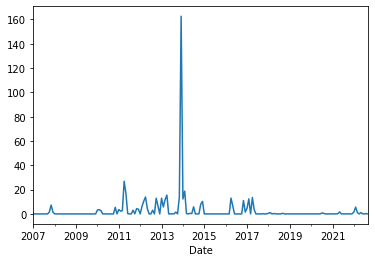

In [3]:
# dataset creation
#coal_data4=coal_data3.copy()
df = ng_data4.set_index("Date")
df['Ng_Con'].plot(style="-")

In [4]:
# Create a dataframe with only the Close Stock Price Column
data_target = df.filter(['Ng_Con'])

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test
# Target Variable: Close stock price value

training_data_len = math.ceil(len(target)* 0.8) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [9.62401761e-03],
       [4.49653781e-02],
       [9.34113914e-03],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.99429323e-02],
       [2.15725583e-02],
       [1.63454561e-02],
       [0.00000000e+00],


In [5]:
# Create a training dataset containing the last 180-day closing price values we want to use to estimate the 181st closing price value.
train_data = training_scaled_data[0:training_data_len  , : ]

X_train = []
y_train = []
for i in range(80, len(train_data)):
    X_train.append(train_data[i-80:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)  #(854 values, 180 time-steps, 1 output)

Number of rows and columns:  (72, 80, 1)


In [6]:
# We add the LSTM layer and later add a few Dropout layers to prevent overfitting.
# Building a LTSM model with 50 neurons and 4 hidden layers. We add the LSTM layer with the following arguments:
# 50 units which is the dimensionality of the output space
# return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence input_shape as the shape of our training set.
# When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped.
# Thereafter, we add the Dense layer that specifies the output of 1 unit.
# After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error.

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

2023-02-25 12:40:54.392517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Getting the predicted stock price
test_data = training_scaled_data[training_data_len - 80: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[training_data_len : , : ]
for i in range(80,len(test_data)):
    X_test.append(test_data[i-80:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (37, 80, 1)


In [8]:
import mlflow
import mlflow.keras

2023/02/25 12:40:55 INFO mlflow.tracking.fluent: Experiment with name 'forecasting-model-natural-gas' does not exist. Creating a new experiment.
2023/02/25 12:40:55 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Cmd('git') failed due to: exit code(1)
  cmdline: git version
  stderr: 'xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun'


Epoch 1/100
3/3 - 7s - loss: 0.0147 - val_loss: 1.0478 - 7s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.0140 - val_loss: 1.0520 - 395ms/epoch - 132ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0140 - val_loss: 1.0533 - 354ms/epoch - 118ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0141 - val_loss: 1.0547 - 354ms/epoch - 118ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0140 - val_loss: 1.0517 - 357ms/epoch - 119ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0145 - val_loss: 1.0470 - 350ms/epoch - 117ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0143 - val_loss: 1.0474 - 371ms/epoch - 124ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0143 - val_loss: 1.0409 - 358ms/epoch - 119ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0142 - val_loss: 1.0448 - 354ms/epoch - 118ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0141 - val_loss: 1.0519 - 354ms/epoch - 118ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0142 - val_loss: 1.0558 - 354ms/epoch - 118ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0141 - val_loss: 1.0552 - 352ms/epoch - 117ms/step
Epoch 13/100
3/3 - 

Epoch 100/100
3/3 - 0s - loss: 0.0141 - val_loss: 1.0525 - 352ms/epoch - 117ms/step
1/1 [==============================] - 1s 1s/step


INFO:tensorflow:Assets written to: /var/folders/j9/qhmtvh7x7078vxjxd4t6fnh80000gn/T/tmp9sei0b2r/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/j9/qhmtvh7x7078vxjxd4t6fnh80000gn/T/tmp9sei0b2r/model/data/model/assets
2023/02/25 12:42:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/nikhileshwaravs/opt/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."
2023/02/25 12:42:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/j9/qhmtvh7x7078vxjxd4t6fnh80000gn/T/tmpn5iuupbn/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/j9/qhmtvh7x7078vxjxd4t6fnh80000gn/T/tmpn5iuupbn/model/data/model/assets


2/2 [==============================] - 0s 18ms/step


/var/folders/j9/qhmtvh7x7078vxjxd4t6fnh80000gn/T/ipykernel_9346/1121038569.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_en


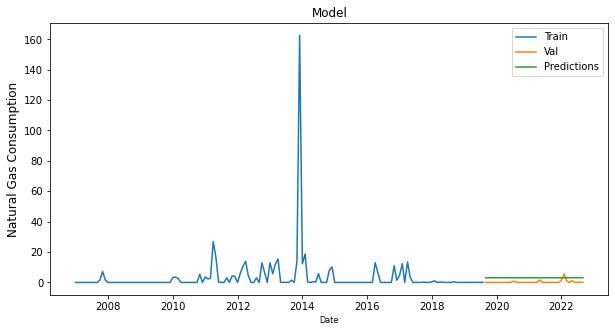

Mean Absolute error is 2.868392987173957
MAPE is inf
RMSE is 2.9005490087296284


In [9]:
# Fitting the RNN to the Training set
batch_size = 32
n_epochs = 100

# Set mlflow experiment name


mlflow.set_experiment('forecasting-model-natural-gas')

mlflow.tensorflow.autolog()

mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Train model with mlflow tracking
experiment_name = "forecasting-model-natural-gas"

# Check if experiment exists, if not, create it
try:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
except:
    experiment_id = mlflow.create_experiment(experiment_name)

# Start a new run
with mlflow.start_run(experiment_id=experiment_id,nested=True):
    # Log hyperparameters
    #mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    mlflow.set_tag("data scientist", "kb")
    mlflow.set_tag("model", model)
    mlflow.log_param('batch_size', batch_size)
    mlflow.log_param('n_epochs', n_epochs)
    

    #mlflow.log_metric('n_val_samples', len(X_val))

    # Train model
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                        validation_data=(X_test,y_test), verbose=2)
    #model_info = mlflow.tensorflow.log_model(model,artifact_path="model",registered_model_name="LSTM")

    # Log training metrics
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    mlflow.log_metric('train_loss', train_loss)
    mlflow.log_metric('val_loss', val_loss)

    # Log model
    mlflow.keras.log_model(model,'model')

    # Evaluate model on validation set
    predicted_en = model.predict(X_test)
    predicted_en = sc.inverse_transform(predicted_en)
    #charting outputs
    train = data_target[:training_data_len]
    valid = data_target[training_data_len:]
    valid['Predictions'] = predicted_en
    
    fig = plt.figure(figsize=(10,5))

    plt.title('Model')
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Natural Gas Consumption', fontsize=12)
    plt.plot(train['Ng_Con'])
    plt.plot(valid[['Ng_Con', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
    plt.show()
    
    #MAE
    n=mean_absolute_error(valid.Ng_Con, valid["Predictions"])
    print("Mean Absolute error is",n)
    #MAPE
    k=np.mean(np.abs((valid.Ng_Con - valid["Predictions"]) / valid.Ng_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(valid.Ng_Con, valid["Predictions"]))
    print("RMSE is",r)
    mlflow.log_param("model", "LSTM")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "my-plot.png")
    

In [10]:
#MAE
n=mean_absolute_error(valid.Ng_Con, valid["Predictions"])
print("Mean Absolute error is",n)

Mean Absolute error is 2.868392987173957


In [11]:
#MAPE
k=np.mean(np.abs((valid.Ng_Con - valid["Predictions"]) / valid.Ng_Con)) * 100
print("MAPE is",k)

MAPE is inf


In [12]:
#RMSE
r=math.sqrt(mean_squared_error(valid.Ng_Con, valid["Predictions"]))
print("RMSE is",r)

RMSE is 2.9005490087296284
